In [1]:
# NOTEBOOK IMPORTS
import os, glob, warnings, pickle, re
import numpy as np
from shutil import copyfile, rmtree
from datetime import datetime
from fuzzywuzzy import process

# IMAGE IMPORTS
# from PIL import Image

# GIS IMPORTS
from affine import Affine
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point, MultiPoint, box
import rasterio as rio
import contextily as cx

# PLOTTING IMPORTS
import matplotlib.pyplot as plt

# CUSTOM UTILITIES
from IndexUtils import * 
from TileUtils import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")
initialize = False

In [2]:
input_dir = r"C:\Users\fhace\Desktop\FIRMs\data\Uncompress\\"

In [3]:
stateplanes = gpd.read_file(f"{data_dir}/AAA_ReferenceDatasets/stateplane.shp")

init_databases(f"{data_dir}/AAA_ReferenceDatasets/")

True

In [4]:
# LIST ALL IMAGES IN DIRECTORY
image_files = glob.glob(f"{input_dir}/*")

# FILTER IMAGES USING HEURISTICS TO GET TILEINDICES
patterns = ["IND", "_1."]
index_files = [file for pattern in patterns for file in glob.glob(input_dir + "\\*" + pattern + "*")]
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files.extend(filtered_files)

# GET ACTUAL TILES
tiles       = list(set(image_files) - set(index_files))
tiles_bns   = [os.path.basename(tile).split(".")[0] for tile in tiles]

with open(f"{data_dir}/AAA_ReferenceDatasets/IndexCoords.pkl", 'rb') as handle:
    dict = pickle.load(handle)

In this cell we create the Tile database based on the identified BBOXs...

In [5]:
import re
tile_names = list(dict.keys())

processed_indices = list(dict.keys())

tile_keys = [findIndexKey(a) for a in tile_names]
inde_keys = [findIndexKey(a) for a in processed_indices]

global db
db = {}

# FOR EACH INDEX KEY
for key in np.unique(inde_keys):
    # GET ALL INDICES THAT HAVE THAT KEY
    match_indices = [processed_indices[i] for i, a in enumerate(inde_keys) if a == key]

    # EXTRACT ALL THE TILE INFORMATION FROM THE MATCHING INDICES
    found_tiles   = [getIndivDict(dict, index) for index in match_indices]
    all_tiles = sum(found_tiles, [])

    # PUT IN OUTPUT STRUCTURE
    temp = pd.DataFrame(all_tiles)
    temp = temp.fillna("")
    db[key] = temp

Here we supplement that database with all existing world files...

In [6]:
# READ ALL THE WORLD FILES FROM A DIRECTORY AND CREATE A DATAFRAME
data = read_world_files_from_directory(input_dir)
columns = ['filename', 'line1', 'line2', 'line3', 'line4', 'line5', 'line6']
df = pd.DataFrame(data, columns=columns)

# CONVERT ALL READ PARAMETERS TO NUMERIC
for col in [col for col in df.columns if "line" in col]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# FIND GEOMETRY FOR EACH ROW
df['key']   = df['filename'].apply(findTileKey, db=db)  # FIND THE KEY FOR THE FILENAME
df['key_n'] = pd.to_numeric(df['key'], errors='coerce') # CONVERT IT TO NUMERIC
df["GEOID"] = df["key_n"].apply(getGEOID)               # GET GEOID FOR EACH INDEX
df['county_polygon'] = df["GEOID"].apply(getGeometry)   # USE FIND GEOMETRY FUNCTION

# HEURISTICS - DEFINE WHETHER THE FOUND TRANSFORM IS STATEPLANE 
# BY IT'S SCALE. IF IT'S BIGGER THAN 1, PROBABLY (MOST FILE'S RESOLUTION IS < 0.5 m)
df['STATEPLANE'] = df['line1'] > 1

# INTERSECT DF WITH STATE PLANE SHAPEFILE 
geo_df   = gpd.GeoDataFrame(df, geometry=df['county_polygon']).set_crs("EPSG:3857").to_crs("EPSG:4326")
df_plane = geo_df.overlay(stateplanes, how='intersection')

# CALCULATE EPSG CODE
df['epsg'] = geo_df.apply(getEPSG, df_plane=df_plane, axis=1)
del geo_df, df_plane

df['geotransform'] = df['filename'].apply(getGeotransform, input_dir=input_dir)
df['affine'] = df['geotransform'].apply(getAffine)

In [7]:
webmercator = []

RLNN = None
def notify(mess, level=2):
    if level < 4:
        print(mess)

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    fn = row['filename'].split(".")[0]
    image_files = glob.glob(f'{os.path.join(input_dir, fn)}*[!w]')

    if pd.isna(row['epsg']):
        notify(f"NO EPSG {fn}")
        webmercator.append([])
        continue

    if len(image_files) == 0:
        notify(f"NO CORRESPONDING IMAGE {fn}")
        webmercator.append([])
        continue
    bounds, RLNN = findBounds(image_files[0], model=RLNN, verbose=False)

    if len(bounds[0]) == 0:
        notify(f"NO BOUNDS FOUND {image_files[0]}")
        webmercator.append([])
        continue

    bbox = bounds[0].boxes.xyxy.numpy()[0]

    in_crs  = rio.crs.CRS.from_string(f"{row['epsg']}")
    out_crs = rio.crs.CRS.from_epsg(f"3857")

    left, bottom = row['affine'] * (bbox[0], bbox[1])
    right, top   = row['affine'] * (bbox[2], bbox[3])

    new_bbox = rio.warp.transform_bounds(in_crs, out_crs, left, bottom, right, top)
    webmercator.append(new_bbox)
    # print(bbox, [bottom, left, top, right], new_bbox)

df["webmerc"] = webmercator

  0%|          | 0/178 [00:00<?, ?it/s]

NO BOUNDS FOUND C:\Users\fhace\Desktop\FIRMs\data\Uncompress\48201C0195M.tif
NO BOUNDS FOUND C:\Users\fhace\Desktop\FIRMs\data\Uncompress\48201C0415M.tif
NO BOUNDS FOUND C:\Users\fhace\Desktop\FIRMs\data\Uncompress\48201C0970M.tif
NO BOUNDS FOUND C:\Users\fhace\Desktop\FIRMs\data\Uncompress\48201C1030L.tif


In [8]:
# Function to convert [left, bottom, right, top] to a shapely Polygon
def bbox_to_polygon(bbox):
    if len(bbox) == 0:
        return None
    left, bottom, right, top = bbox
    return box(left, bottom, right, top)

# Apply the function to the 'bbox' column
df['geometry'] = df['webmerc'].apply(bbox_to_polygon)
gdf = gpd.GeoDataFrame(df)
gdf.dropna(axis=0)

for key in gdf.keys():
    if key == 'geometry':
        continue
    gdf[key] = gdf[key].astype(str)

In [9]:
gdf.to_file(r"C:\Users\fhace\Desktop\FIRMs\data\WorldFiles.shp")

In [11]:

def getDimensions(world_file, input_dir):
    # GETS DIMENSIONS OF IMAGE FOR RESPECTIVE WORLD FILE
    image_files = glob.glob(f'{os.path.join(input_dir, world_file.split(".")[0])}*[!w]')
    if len(image_files) == 0:
        return None, None
    
    with Image.open(os.path.join(input_dir, image_files[0])) as img:
        width, height = img.size

        return width, height

test = df['filename'].apply(getDimensions, input_dir=r"D:\RECTDNN\test",)
test = np.array(test)
test['width'] = test[:, 0]
test['height'] = test[:, 1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [28]:
dict.keys()

dict_keys(['480035IND0_0490.jpg', '480035IND0_0789.jpg', '480035IND0_0990.jpg', '480035IND0_1084.jpg', '480035IND0_1091.jpg', '480038IND0_1185.jpg', '480045IND0_0186.jpg', '480045IND0_0189.jpg', '480045IND0_0486.jpg', '480045IND0_0678.jpg', '480045IND0_0791.jpg', '480045IND0_0890.jpg', '480045IND0_1184.jpg', '480045IND0_1283.jpg', '480046IND0_0780.jpg', '480233IND0_0382.jpg', '480266IND0.tif', '480267IND0.tif', '480267IND0_0581.jpg', '480269IND0.tif', '480269IND0_0992.jpg', '480287IND0_0281.jpg', '480287IND0_0288.jpg', '480287IND0_0382.jpg', '480287IND0_0985.jpg', '480296IND0_0982.jpg', '480296IND0_0985.jpg', '480296IND0_0987.jpg', '480296IND0_1279.jpg', '48029CIND0.tif', '48029CIND0A.tif', '48029CIND0B.tif', '48029CIND0C.tif', '48029CIND0D.png', '48029CIND0_0296.tif', '480304IND0_0182.jpg', '480304IND0_1077.jpg', '480304IND0_1287.jpg', '480307IND0_0686.jpg', '48039CIND0.tif', '480423IND0.tif', '480423IND0_0384.jpg', '480424IND0.tif', '48071CIND0A.tif', '481271IND0.tif', '481271IND0A.t

In [36]:
dict['480035IND0_0990.jpg']["48003503508"]['data']

In [20]:
def findTileDatabase(p):
    test = db.get(findIndexKey(p), None)
    if test is None:
        for i in [6, 5]:
            if test is not None:
                continue
            test = db.get(findIndexKey(p)[:i], None)
    return test

bad = 0
tile_coords = []
for i, p in tqdm(enumerate(tiles_bns), total=len(tiles_bns)):
    # FIND TILES 
    curr_db = findTileDatabase(p)
    if curr_db is None or curr_db.empty:
        bad = bad+1
        print(f"COULD NOT FIND INDEX {p}")
        continue

    # KEEP NUMERIC PART OF TILE NAME
    p = re.sub(r"[^0-9]", "", p) 

    # GET EQUAL-LENGTH TILENAMES FOR MATCHING
    tns = [a[:len(p)] for a in curr_db['tile'].tolist()]

    # PERFORM MATCHING
    match, score = process.extractOne(p, tns)
    if score > 90:
        tile_coords.append(curr_db[curr_db['tile'] == match]["coords"].tolist())
    else:
        bad = bad+1
        print(f"COULD NOT FIND TILE {(p, match, process.extract(p, tns))}")
        tile_coords.append([])

  0%|          | 0/1726 [00:00<?, ?it/s]

COULD NOT FIND TILE ('482010160', '48201C036', [('48201C036', 78)])
COULD NOT FIND TILE ('482010735', '48201C036', [('48201C036', 78)])
COULD NOT FIND TILE ('480290637', '', [('', 0), ('', 0), ('', 0), ('', 0)])
COULD NOT FIND TILE ('4854880030', '4854880020', [('4854880020', 90), ('485488005D', 80), ('485488G005', 80), ('', 0)])
COULD NOT FIND TILE ('4812710002', '4812710003', [('4812710003', 90)])
COULD NOT FIND TILE ('482010170', '48201C036', [('48201C036', 67)])
COULD NOT FIND TILE ('4800450008', '4800450050', [('4800450050', 90), ('4800450007', 90), ('4800450054', 80), ('4800450029', 80), ('4800450046', 80)])
COULD NOT FIND TILE ('4800450018', '4800450050', [('4800450050', 80), ('4800450054', 80), ('4800450007', 80), ('4800450029', 80), ('4800450046', 80)])
COULD NOT FIND TILE ('4800450018', '4800450050', [('4800450050', 80), ('4800450054', 80), ('4800450007', 80), ('4800450029', 80), ('4800450046', 80)])
COULD NOT FIND TILE ('4800350225', '4800350625', [('4800350625', 90), ('4800

In [22]:
len(tiles_bns)

1726

In [ ]:
def filterItems(index_list, elements):
    for e in elements:
        if e in index_list:
            index_list.remove(e)
    return index_list

gen_tile_list = []
gen_bbox_list = []

for k, v in dict.items():
    index_list = list(v.keys())
    index_list = filterItems(index_list, [None, 'county', 'transform_info'])

    coord_list = [v[a]['coords'] for a in index_list]

    gen_tile_list.extend(index_list)
    gen_bbox_list.extend(coord_list)

In [ ]:
gen_tile_list = [re.sub("[^0-9]", "", x) for x in gen_tile_list]
tile_names    = [re.sub("[^0-9]", "", x) for x in tile_names]  

In [ ]:
stuff = {}

for i, p in tqdm(enumerate(tile_names), total=len(tile_names)):
    name_list = [a[:len(p)] for a in gen_tile_list]
    matches = process.extract(p, name_list)
    # print(p, matches)
    out = []
    for t in matches:
        bboxes = []
        if t[1] > 90:
            bboxes.extend([gen_bbox_list[i] for i in range(len(name_list)) if name_list[i] == t[0]])
        stuff[p] = bboxes

  0%|          | 0/1406 [00:00<?, ?it/s]

In [ ]:
def findRoads(image, model=None, num_classes=2, num_pyramids=2,
                cnn_run_params=None, cnn_creation_params=None, device="cuda",
                model_checkpoint=f"{data_dir}/FANN/checkpoint_101023.pth"):
    
    if cnn_run_params is None:
        cnn_run_params = {
            "tilesize"   : 2048,
            "edges"      : 0,
            "dims_rep"   : None,
            "n_pyramids" : num_pyramids,
            "num_dim"    : num_classes,
            "device"     : device
        }
    
    if cnn_creation_params is None:
        cnn_creation_params = {
            "num_classes" : num_classes,
            "inputsize"   : num_pyramids,
        }
    
    # Input handling
    if isinstance(image, np.ndarray):
        image = [image] # Make iterable if needed
    
    # Initialize model if needed
    if model is None:
        model = TPNN(**cnn_creation_params)
        model.load_state_dict(torch.load(model_checkpoint)['model_state_dict'])
    model = model.to(device)
    
    # PROCESS IMAGE
    for im in image:
        outputs, _ = split_and_run_cnn(im, model, **cnn_run_params)
    
    # background, grid, roads = outputs[:, :, 0], outputs[:, :, 1], outputs[:, :, 2]
    
    model = model.to("cpu")
    torch.cuda.empty_cache()
    
    outputs = outputs * 255
    outputs = outputs.astype(np.uint8)
    
    # return (background.T, grid.T, roads.T), model
    return outputs, model

def findBounds(image_fn, model=None, 
        model_weights=f"{data_dir}RLNN/weights050124.pt",
        creation_params=None,
        device="cpu",
        ):
    
    if creation_params is None:
        target_size = 512
        original_shapes = []

        # COCO DATASET PARAMS
        category_labels = {
            0 : "County",
            1 : "Tile",
            2 : "Box",
            3 : "Legend"
        }

        categories=[0, 1]

    input_folder = os.path.dirname(os.path.abspath(image_fn))

    # Initialize model
    if model is None:
        model = ultralytics.YOLO(model_weights).to("cpu")

    model = model.to(device)
    
    results = model(image_fn, imgsz=target_size)

    return results, model


def getRoadPoints(fn, model=None):
    # LOAD IMAGE AS NUMPY ARRAY
    image = np.asarray(cv2.imread(fn))

    # RUN CNN
    out, FANN = findRoads(image, model=model)

    # RUN YOLO
    outbbox, RLNN = findBounds(fn)

    # REMOVE ANY CNN OUTSIDE BOUNDS
    bounds = outbbox[0].boxes.xyxy.numpy().astype(np.int32).flatten()
    mask  = np.zeros(out.shape)
    mask[bounds[1]:bounds[3], bounds[0]:bounds[2], :] = 1
    out = out * mask
    out = out.astype(np.uint8)

    # THIN CNN OUTPUTS
    thin = cv2.ximgproc.thinning(out[:, :, 1], thinningType=cv2.ximgproc.THINNING_GUOHALL)

    # OUTPUT X AND Y
    y, x = np.where(np.asarray(thin > 0))

    out_struct = {
        "x" : x,
        "y" : y,
        "FANN" : FANN,
        "RLNN" : RLNN,
        "thin" : thin,
        "raw"  : out,
        "bbox" : outbbox
    }
    
    return out_struct

In [ ]:
def findIntersections(lines):
    intersections = []
    for i in tqdm(range(len(lines))):
        for j in range(i+1, len(lines)):
            line1 = lines[i][0]
            line2 = lines[j][0]

            x1, y1, x2, y2 = line1
            x3, y3, x4, y4 = line2

            # Calculate intersection point
            denominator = ((x1 - x2) * (y3 - y4)) - ((y1 - y2) * (x3 - x4))
            if denominator != 0:
                intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
                intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

                # Add intersection point to list
                intersections.append((int(intersect_x), int(intersect_y)))
    return intersections

def findInetersections_vectorized(lines):
    intersections = []

    # Convert lines to numpy array for easier manipulation
    lines = lines[:, 0, :]  # Extracting the lines from the unnecessary dimensions

    # Extracting line coordinates
    x1, y1, x2, y2 = lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3]

    # Reshaping to make calculations easier
    x1, y1, x2, y2 = x1.reshape(-1, 1), y1.reshape(-1, 1), x2.reshape(-1, 1), y2.reshape(-1, 1)

    # Calculate differences and determinants
    dx, dy = x2 - x1, y2 - y1
    det = dx * dy[:, np.newaxis] - dy * dx[:, np.newaxis]

    # Check for non-parallel lines
    non_parallel_mask = det != 0

    # Calculate intersection points
    intersect_x = ((x1 * y2 - y1 * x2) * dx - (x1 - x2) * (x1 * dy - y1 * dx)) / det
    intersect_y = ((x1 * y2 - y1 * x2) * dy - (y1 - y2) * (x1 * dy - y1 * dx)) / det

    # Check for valid intersections
    valid_mask = (intersect_x >= 0) & (intersect_y >= 0) & (intersect_x < image.shape[1]) & (intersect_y < image.shape[0])

    # Filter out invalid intersections and non-parallel lines
    valid_intersections = np.column_stack((intersect_x[valid_mask & non_parallel_mask], intersect_y[valid_mask & non_parallel_mask]))

    # Convert intersection points to integer coordinates
    valid_intersections = valid_intersections.astype(int)

    # Remove duplicate intersections
    valid_intersections = np.unique(valid_intersections, axis=0)

    return valid_intersections

def toTF(a):
    a[a > 0] = 1
    a[a <= 0] = 0
    return a

def filterIntersections(inters, lines, fn):
    # APPROACH WITH IMAGE FILTERING. DOESNT WORK
    image_filter = np.asarray(cv2.imread(fn) * 0)
    inter_filter = np.asarray(cv2.imread(fn) * 0)[:, :, 0]

    # Plot the lines
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_filter, (x1, y1), (x2, y2), (255, 255, 255), 2)

    image_filter = image_filter[:, :, 0]
    # CREATE IMAGE MASK
    # Extract x, y coordinates of intersection points
    x_coords, y_coords = zip(*inters)
    # Set the intersection points to white (255) in the mask
    inter_filter[y_coords, x_coords] = 255
    print(inter_filter.shape)
    print(image_filter.shape)


    return toTF(image_filter) * toTF(inter_filter)

def findInetersections_shapely(lines): 
    line_strings = [LineString([(line[0][0], line[0][1]), (line[0][2], line[0][3])]) for line in lines]

    # Create a GeoDataFrame with LineString objects
    gdf = gpd.GeoDataFrame(geometry=line_strings)

    # Calculate intersections
    temp = gdf.unary_union.intersection(gdf.geometry)
    intersection_points = gpd.GeoSeries([point for point in temp if isinstance(point, MultiPoint) or isinstance(point, Point)])
    intersections = gpd.GeoDataFrame(geometry=intersection_points.explode(index_parts=False)).reset_index(drop=True)
    return intersections

fn = tiles[4]
points = getRoadPoints(fn, )

image = np.asarray(cv2.imread(fn))

# Perform Hough Line Transform
lines  = cv2.HoughLinesP(points['thin'], 1, np.pi/720, threshold=20, minLineLength=20, maxLineGap=50)
inters = findInetersections_shapely(lines)

# Plot the lines
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Convert BGR image to RGB for plotting
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)

  0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2024-05-13_19-10-57\Inputs\4800350495B.jpg: 512x512 1 bounds, 283.4ms
Speed: 0.0ms preprocess, 283.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)


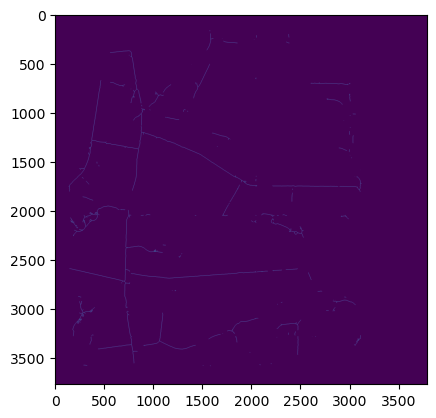

In [ ]:
plt.imshow(points['thin'])

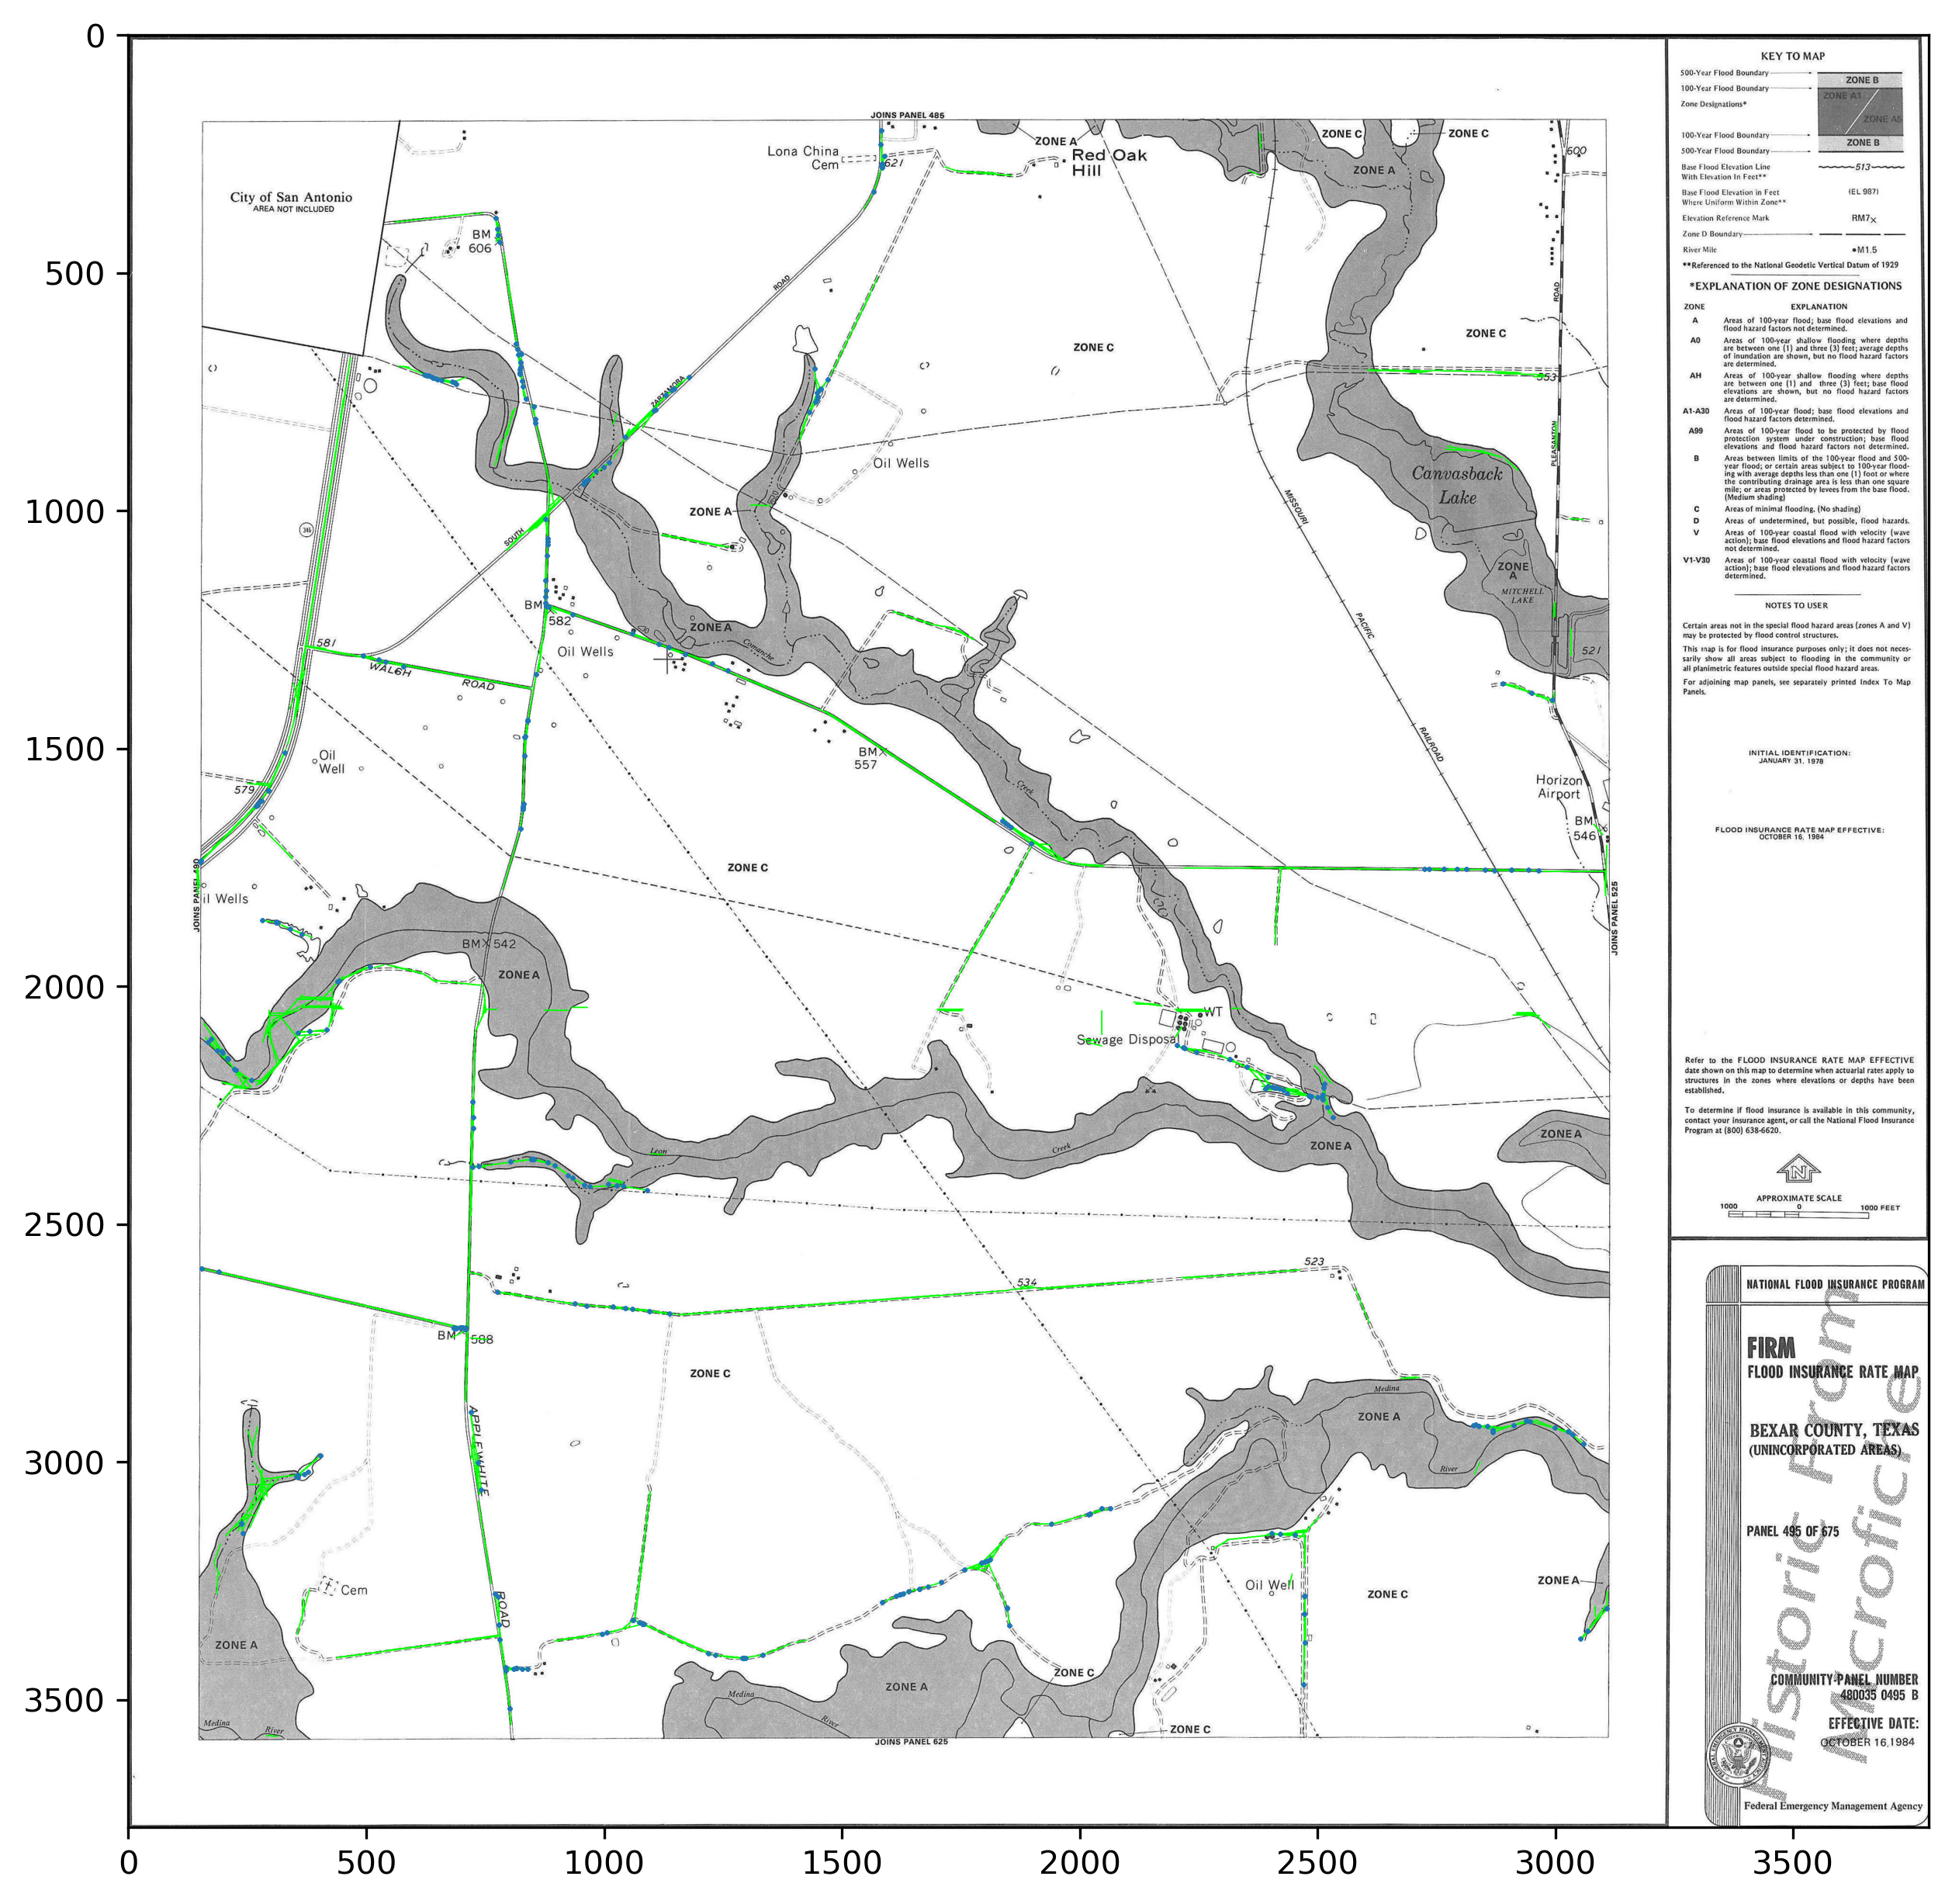

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
ax.imshow(image_rgb)
ax.scatter(inters.geometry.x.tolist(), inters.geometry.y.tolist(), marker='x', s=0.5)
fig.savefig("test.png")

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
import pyproj

def longitude_to_utm_zone(lon):
    """Convert longitude to UTM zone number."""
    return int((lon + 180) / 6) + 1

# Example polygon data
polygons = [
    Polygon([(0, 0), (1, 0), (1, 1), (0, 1), (0, 0)]),
    Polygon([(-10, -10), (-9, -10), (-9, -9), (-10, -9), (-10, -10)]),
    # Add more polygons as needed
]

gdf = gpd.GeoDataFrame({'geometry': polygons})

gdf['centroid'] = gdf.geometry.centroid
gdf['longitude'] = gdf.centroid.x
gdf['utm_zone'] = gdf['longitude'].apply(longitude_to_utm_zone)

print(gdf[['geometry', 'centroid', 'longitude', 'utm_zone']])

                                            geometry  \
0  POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....   
1  POLYGON ((-10.00000 -10.00000, -9.00000 -10.00...   

                    centroid  longitude  utm_zone  
0    POINT (0.50000 0.50000)        0.5        31  
1  POINT (-9.50000 -9.50000)       -9.5        29  
